<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
unique_words=data['Word'].nunique()
unique_tags=data['Tag'].nunique()

In [4]:
print(f"unique_words {unique_words} unique_tags {unique_tags}")

unique_words 35178 unique_tags 17


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)

In [6]:
tags = list(set(data["Tag"].values))
num_tags=len(tags)

In [7]:
print(f"num_words {num_words} num_tags {num_tags}")

num_words 35179 num_tags 17


### Task 3: Retrieve Sentences and Corresponsing Tags

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent=1
        self.data=data
        agg_func=lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_func)
        self.sentences=[s for s in self.grouped]

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
print(f"sentences {sentences[0]}")

sentences [('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


### Task 4: Define Mappings between Sentences and Tags

In [11]:
word2idx={w: i+1 for i,w in enumerate(words)}
tag2idx={t:i for i,t in enumerate(tags)}

In [12]:
word2idx

{'suspecting': 1,
 'Robbery': 2,
 'Khel': 3,
 '7.00E+07': 4,
 'Shadow': 5,
 'Gobernador': 6,
 'paroled': 7,
 'marks': 8,
 'airstrikes': 9,
 'target': 10,
 'Oresund': 11,
 'Orjiako': 12,
 'Fats': 13,
 'Verde': 14,
 'littered': 15,
 'audiences': 16,
 'land-grab': 17,
 'Mountain': 18,
 'graduate': 19,
 'Panjwayi': 20,
 'Karroubi': 21,
 'Caucus': 22,
 'Davide': 23,
 'Tegucigalpa': 24,
 'ready': 25,
 'stints': 26,
 '733': 27,
 'spot': 28,
 'predecessor': 29,
 'Tanzania-based': 30,
 'Highly-Indebted': 31,
 'Medicare': 32,
 'Qomi': 33,
 'Rebel': 34,
 'remembered': 35,
 'Jennifer': 36,
 'lipstick': 37,
 'Man': 38,
 'underscored': 39,
 'lattes': 40,
 '216': 41,
 'Yugoslavian': 42,
 'boded': 43,
 'rate': 44,
 '255': 45,
 'undefeated': 46,
 'connections': 47,
 'sustainability': 48,
 'criminal': 49,
 'Landmarks': 50,
 'Berthiaume': 51,
 'credible': 52,
 'service-oriented': 53,
 'Khayber': 54,
 'Weyn': 55,
 'Philipp': 56,
 'kick-off': 57,
 'Chargers': 58,
 'malpractice': 59,
 'Province': 60,
 'pano

### Task 5: Padding Input Sentences and Creating Train/Test Splits

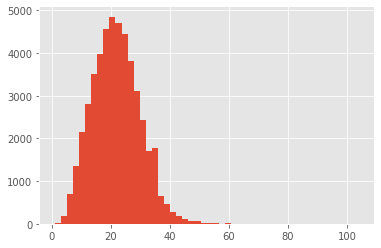

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len=50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i) for i in y]

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

### Task 7: Train the Model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

### Task 8: Evaluate Named Entity Recognition Model